## Train mrcnn

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
import os
os.chdir('/content/drive/MyDrive/MaskRCNN/codeSnippet')

In [ ]:
import tensorflow as tf
# !pip install tensorflow==1.5 --upgrade
print(tf.__version__)

# !pip install keras==2.2.5 --upgrade
import keras
print(keras.__version__)

!pip install -r requirements.txt
!python setup.py clean --all install

print(tf.test.gpu_device_name())

In [ ]:
os.chdir('/content/drive/MyDrive/MaskRCNN/codeSnippet/samples/codeSnippet')
!python codeSnippet.py train --dataset=/content/drive/MyDrive/MaskRCNN/codeSnippet/samples/codeSnippet/dataset_rectangle --weights=coco

# Evaluation of MRCNN

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.chdir('/content/drive/MyDrive/MaskRCNN/codeSnippet')
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/MaskRCNN/codeSnippet")

In [6]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

# from samples.balloon import balloon
sys.path.append(os.path.join(ROOT_DIR, "samples/codeSnippet"))
import codeSnippet


%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

## Configuration

In [99]:
config = codeSnippet.CustomConfig()
CODE_SNIPPET_DIR = os.path.join(ROOT_DIR, "samples/codeSnippet/dataset_rectangle")
print(CODE_SNIPPET_DIR)

/content/drive/MyDrive/MaskRCNN/codeSnippet/samples/codeSnippet/dataset_rectangle


In [105]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
# config.display()

In [106]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [107]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load validation dataset

In [108]:
# Load validation dataset
dataset = codeSnippet.CustomDataset()
dataset.load_custom(CODE_SNIPPET_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 20
Classes: ['BG', 'codeSnippet']


## Load model

In [109]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [110]:
# Set path to codeSnippet weights file
# Or, load the last model you trained
weights_path = model.find_last()
# weights_path = '/content/drive/MyDrive/MaskRCNN/codeSnippet/logs/codesnippet20210212T0942/mask_rcnn_codesnippet_0030.h5'
print(weights_path)

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

/content/drive/MyDrive/MaskRCNN/codeSnippet/logs/codesnippet20210212T0942/mask_rcnn_codesnippet_0040.h5
Loading weights  /content/drive/MyDrive/MaskRCNN/codeSnippet/logs/codesnippet20210212T0942/mask_rcnn_codesnippet_0040.h5
Re-starting from epoch 40


## Run detection

image ID: codeSnippet.Screenshot (48).png (5) /content/drive/MyDrive/MaskRCNN/codeSnippet/samples/codeSnippet/dataset_rectangle/val/Screenshot (48).png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  237.00000  max:  685.00000  int32
gt_mask                  shape: (56, 56, 1)           min:    0.00000  max:    1.00000  bool


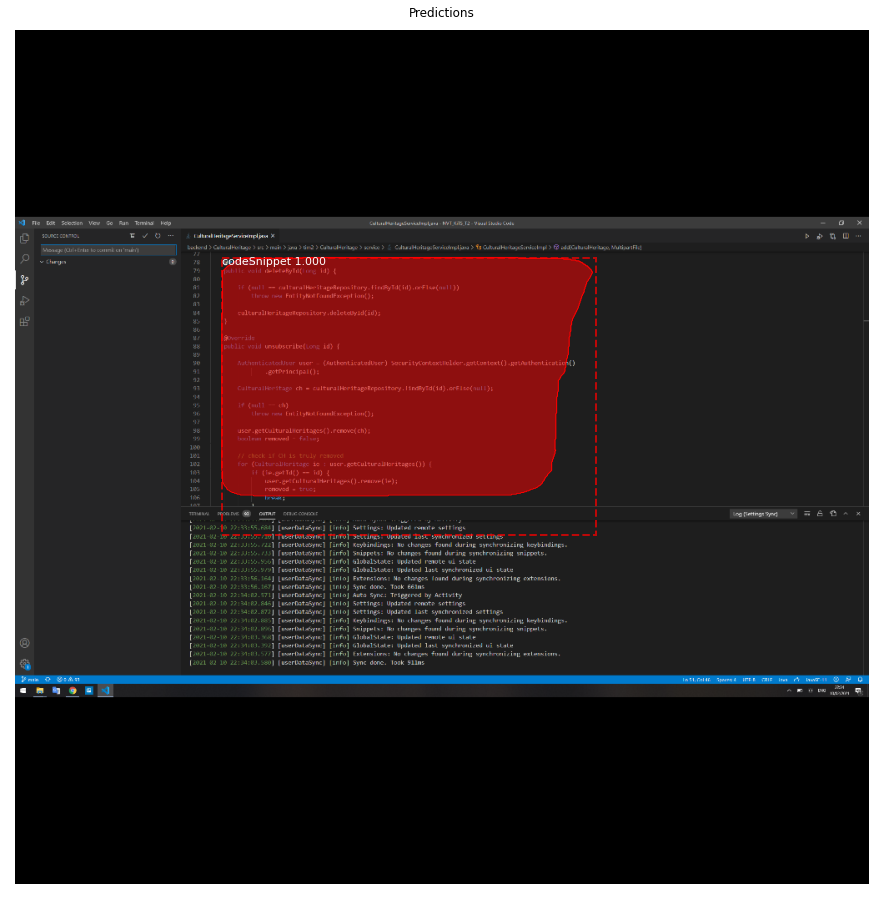

In [111]:
image_id = random.choice(dataset.image_ids)
# image_id = 10
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]

# prikaz bounding boxa
# y1, x1, y2, x2 = r['rois'][0]
# p = Rectangle((x1, y1), x2-x1, y2- y1, linewidth=1, edgecolor='b', facecolor='none')
# ax.imshow(image)
# ax.add_patch(p)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Crop & save img

[[273 169 603 501]]
[122, 422, 947, 1252]


<Figure size 6000x3600 with 0 Axes>

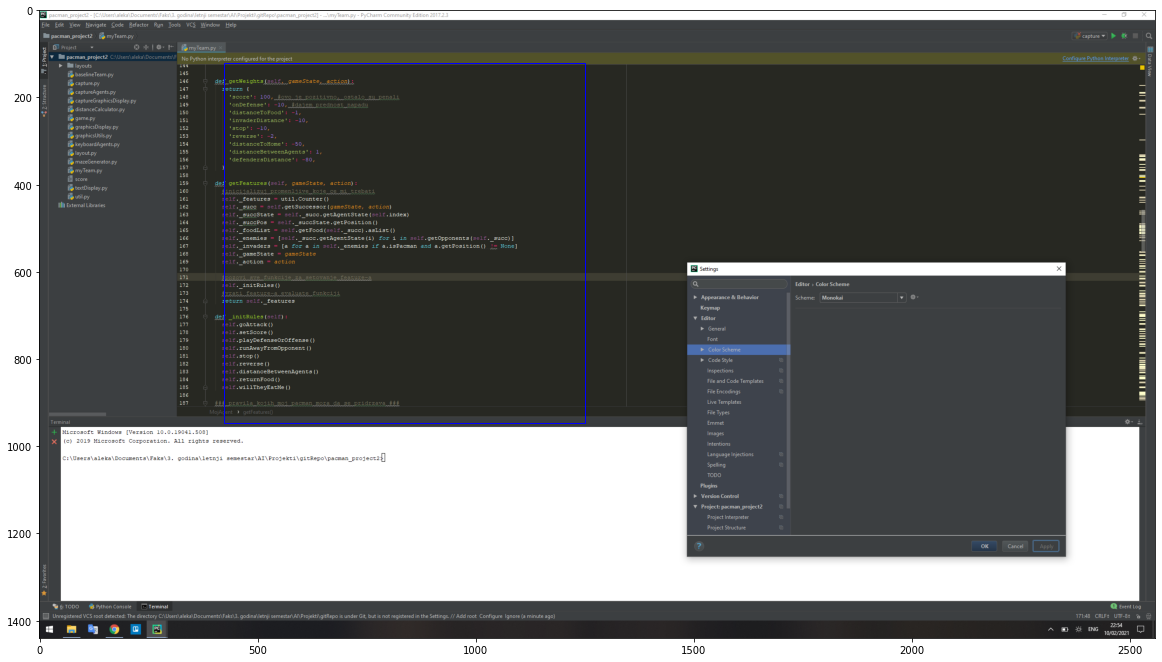

In [15]:
# iscrtavanje slika i grafika unutar samog browsera
%matplotlib inline 
# prikaz vecih slika 
matplotlib.rcParams['figure.figsize'] = 20,12
matplotlib.pyplot.figure(dpi=300)
from matplotlib.patches import Rectangle

print(r['rois'])
# skalirano za pravu sliku
ratioX = 2560 / 1024
ratioY = 416  / 1024

y1, x1, y2, x2 = r['rois'][0]

empty_space = 224 # this a height of a black empty space from previous image
y1 = int( (y1 - empty_space) * ratioX)
x1 = int(x1 * ratioX)
y2 = int( (y2 - empty_space) * ratioX)
x2 = int(x2 * ratioX)

width = x2-x1
height = y2- y1
print([y1, x1, y2, x2])
p = Rectangle((x1, y1), width, height, linewidth=1, edgecolor='b', facecolor='none')

import cv2
image_from_disk = cv2.imread(dataset.image_reference(image_id))
image_from_disk = cv2.cvtColor(image_from_disk, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots()
ax.imshow(image_from_disk)
ax.add_patch(p)

### save image

In [ ]:
image_from_disk = cv2.imread(dataset.image_reference(image_id))
image_from_disk = cv2.cvtColor(image_from_disk, cv2.COLOR_BGR2RGB)
crop_img = image_from_disk[y1:y1 +height, x1:x1 + width]

# fig, ax = plt.subplots()
# ax.imshow(crop_img)
cv2.imwrite('output/proba.jpg', crop_img)

True

---
# Tesseract OCR





### import and install tesseract

In [72]:
!pip install pytesseract
import pytesseract
!apt install tesseract-ocr
!which tesseract # this is a path where tesseract should be installed
#connect api with tesseract exe file
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 17 not upgraded.
/usr/bin/tesseract


### Function which makes text indentation

In [73]:
import pandas as pd

def get_text_with_indentation(image, config):
    d = pytesseract.image_to_data(image, config=config, output_type=pytesseract.Output.DICT)
    df = pd.DataFrame(d)

    final_text = ''

    # clean up blanks
    df1 = df[(df.conf!='-1')&(df.text!=' ')&(df.text!='')]
    # sort blocks vertically
    sorted_blocks = df1.groupby('block_num').first().sort_values('top').index.tolist()
    for block in sorted_blocks:
        curr = df1[df1['block_num']==block]
        sel = curr[curr.text.str.len()>3]
        char_w = (sel.width/sel.text.str.len()).mean()
        prev_par, prev_line, prev_left = 0, 0, 0
        text = ''
        for ix, ln in curr.iterrows():
            # add new line when necessary
            if prev_par != ln['par_num']:
                text += '\n'
                prev_par = ln['par_num']
                prev_line = ln['line_num']
                prev_left = 0
            elif prev_line != ln['line_num']:
                text += '\n'
                prev_line = ln['line_num']
                prev_left = 0

            added = 0  # num of spaces that should be added
            if ln['left']/char_w > prev_left + 1:
                added = int((ln['left'])/char_w) - prev_left
                text += ' ' * added 
            text += ln['text'] + ' '
            prev_left += len(ln['text']) + added + 1
        text += '\n'
        final_text += text

    return final_text


In [ ]:
# Try to read sample image
custom_config = r'-c preserve_interword_spaces=1 --oem 1 --psm 4'
image_for_tesseract = cv2.imread('/content/drive/MyDrive/MaskRCNN/codeSnippet/output/proba.jpg')
image_for_tesseract = cv2.cvtColor(image_for_tesseract, cv2.COLOR_BGR2RGB)
text = get_text_with_indentation(image_for_tesseract, custom_config)
print(text)



---
# Evaluation of MRCNN + Tesseract OCR on test dataset


### cosine similarity

In [75]:
import math
import re
from collections import Counter

WORD = re.compile(r"\w+")


def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)


### Cosine similarity for one image

cosine similarity: 0.9893473716633394


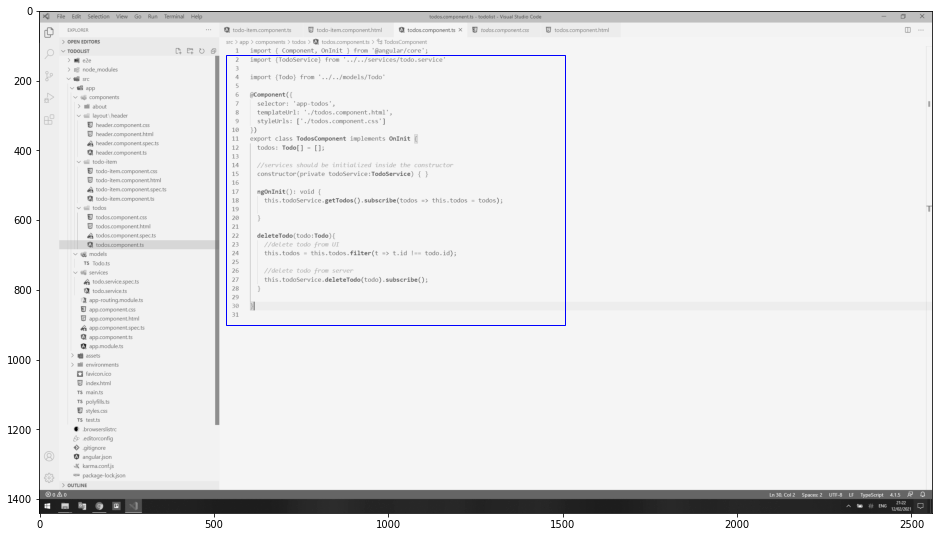

In [148]:
TEST_DIR = '/content/drive/MyDrive/MaskRCNN/codeSnippet/samples/codeSnippet/dataset_rectangle/test'
class_names = ['BG', 'codeSnippet']
custom_config = r'-c preserve_interword_spaces=1 --oem 1 --psm 4 '

# for test_image_name in os.listdir(TEST_DIR):
test_image = cv2.imread(os.path.join(TEST_DIR, 'test images/Screenshot (141).png'))
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
results = model.detect([test_image], verbose=0)

test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
r = results[0]
y1, x1, y2, x2 = r['rois'][0]
width = x2-x1
height = y2- y1
crop_img = test_image[y1:y1 +height, x1:x1 + width]
text_from_image = get_text_with_indentation(crop_img, custom_config)
# print(text_from_image)

text_from_file = open( os.path.join(TEST_DIR, 'test text/141.txt')).read()

cosine = get_cosine(text_to_vector(text_from_image),text_to_vector(text_from_file))
print('cosine similarity:', cosine)


# show bounding box 
ax = get_ax(1)
p = Rectangle((x1, y1), x2-x1, y2- y1, linewidth=1, edgecolor='b', facecolor='none')
ax.imshow(test_image, 'gray')
ax.add_patch(p)



### Avarage cosine similarity

In [149]:
TEST_IMAGE_DIR = '/content/drive/MyDrive/MaskRCNN/codeSnippet/samples/codeSnippet/dataset_rectangle/test/test images'
class_names = ['BG', 'codeSnippet']
custom_config = r'-c preserve_interword_spaces=1 --oem 1 --psm 4 '


def get_text_from_screenshot(test_image_name):
  test_image = cv2.imread(os.path.join(TEST_IMAGE_DIR, test_image_name))
  test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
  results = model.detect([test_image], verbose=0)
  # convert to grayscale
  test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
  # get bounding box
  r = results[0]
  try:
    y1, x1, y2, x2 = r['rois'][0]
    width = x2-x1
    height = y2- y1
    # crop image
    crop_img = test_image[y1:y1 +height, x1:x1 + width]
    text_from_image = get_text_with_indentation(crop_img, custom_config)
    return text_from_image
  except IndexError:
    return ""

def get_text_from_file(test_image_name):
  bracket1 = test_image_name.find("(")
  bracket2 = test_image_name.find(")")
  screehsnot_number = test_image_name[bracket1 + 1: bracket2]
  text_file_name = str(screehsnot_number) + '.txt'
  text_from_file = open( os.path.join(TEST_DIR, 'test text/' + text_file_name)).read()
  return text_from_file

number_of_images = 0
avg_cosine = 0

#iterate over images and calculate similarity
for test_image_name in os.listdir(TEST_IMAGE_DIR):
  text_from_image = get_text_from_screenshot(test_image_name)
  text_from_file = get_text_from_file(test_image_name)

  cosine = get_cosine(text_to_vector(text_from_image),text_to_vector(text_from_file))
  avg_cosine += cosine
  number_of_images +=1

  print(test_image_name)
  print('cosine similarity:', cosine)

avg_cosine /= number_of_images

print("----------------")
print("avarage cosine: ", avg_cosine)

Screenshot (19).png
cosine similarity: 0.8899658227158973
Screenshot (20).png
cosine similarity: 0.9564271898738761
Screenshot (21).png
cosine similarity: 0.7700647063802675
Screenshot (22).png
cosine similarity: 0.9335011409880043
Screenshot (128).png
cosine similarity: 0.9664436065562246
Screenshot (129).png
cosine similarity: 0.8833232771497492
Screenshot (130).png
cosine similarity: 0.7072094464184768
Screenshot (131).png
cosine similarity: 0.7503085784948503
Screenshot (132).png
cosine similarity: 0.9625140996741506
Screenshot (133).png
cosine similarity: 0.8954915500021761
Screenshot (134).png
cosine similarity: 0.7640521539404388
Screenshot (135).png
cosine similarity: 0.868022582346337
Screenshot (136).png
cosine similarity: 0.6765539008845517
Screenshot (137).png
cosine similarity: 0.6085806194501846
Screenshot (138).png
cosine similarity: 0.907799745972579
Screenshot (139).png
cosine similarity: 0.8799617199165926
Screenshot (140).png
cosine similarity: 0.9883472039723841
Scr